# import packages

In [14]:
#Import Pacakges
import pandas as pd
from sbmtm import sbmtm
import graph_tool.all as gt
import pickle
import numpy as np
import pylab as plt
import seaborn as sns
from datetime import datetime
from dateutil import parser
from collections import defaultdict

In [4]:
def mcc_classification(mcc):
    if mcc < 1500:
        return 'Agricultural Services'
    elif mcc < 3000:
        return 'Contracted Services'
    elif mcc < 4800:
        return 'Travel'
    elif mcc < 5000:
        return 'Utility Services'
    elif mcc < 5600:
        return 'Retail Outlet Services'
    elif mcc < 5700:
        return 'Clothing Stores'
    elif mcc < 7300:
        return 'Miscellaneous Stores'
    elif mcc < 8000:
        return 'Business Services'
    elif mcc < 9000:
        return 'Professional Services and Membership Organizations'
    else:
        return 'Government Services'

In [39]:
#filtered_data = pd.read_csv('/Users/ognyansimeonov/Desktop/MAC-MIGS/PhD/Code/Data/Transactions_Data_with_COICOP.csv')
filtered_data = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='Clean_Transfers')
mcc_dict = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='MCC_List', skiprows=10, usecols='A:B', names=['mcc_code', 'Description'])

### data cleaning
# select transactions with amount > 10
filtered_data = filtered_data[filtered_data['amount.value'] > 10]
# select customers with more than 10 transactions
filtered_data = filtered_data[filtered_data['customerId'].map(filtered_data['customerId'].value_counts()) > 10]
# map the mcc_dict to the filtered_data and drop the rows with NaN MCC values
filtered_data['MCC_List'] = filtered_data['externalParty.merchantCategoryCode'].map(mcc_dict.set_index('mcc_code')['Description'])
filtered_data = filtered_data.dropna(subset=['MCC_List'])
# fill the missing carbon emission values with the calculated carbon emission values based on the emission rate of the MCC
# calculate the emission rate of each transaction
filtered_data['emission_rate'] = filtered_data.apply(lambda x: x['transactionFootPrint.carbonEmissionInGrams']/x['amount.value'] if x['amount.value']!=0 else 0, axis=1)
# find the emission rate of each MCC
df_emission_rate = filtered_data.groupby('MCC_List')['emission_rate'].max().sort_values(ascending=True).reset_index().set_index('MCC_List').fillna(0)
# calculate the carbon emission of each transaction where missing
filtered_data['transactionFootPrint.carbonEmissionInGrams'] = filtered_data.apply(lambda x: x['amount.value']*df_emission_rate.loc[x['MCC_List']], axis=1)
filtered_data['mcc_classification'] = filtered_data['externalParty.merchantCategoryCode'].apply(mcc_classification)

df = filtered_data 

# Create a dictionary to store MCC lists for each customer
customer_mcc_dict = {}

# Iterate through the dataframe
for _, row in df.iterrows():
    customer_id = row['customerId']
    mcc = row['MCC_List']

    # Check if the customer_id is already in the dictionary
    if customer_id in customer_mcc_dict:
        customer_mcc_dict[customer_id].append(mcc)
    else:
        customer_mcc_dict[customer_id] = [mcc]

# build a network

<Axes: ylabel='Frequency'>

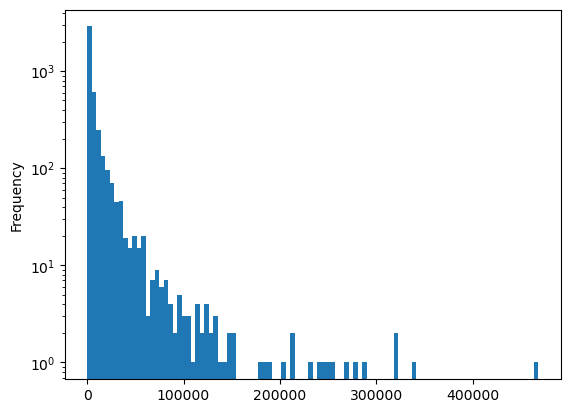

In [65]:
df_weight_network = filtered_data.groupby(['customerId','MCC_List'])['amount.value'].sum().reset_index()
df_weight_network['amount.value'].plot(kind='hist', bins=100, logy=True)

In [66]:
print(df_weight_network['amount.value'].max())
print(df_weight_network['amount.value'].min())

467650
15


In [67]:
df_weight_network['amount.value'] = np.log10(df_weight_network['amount.value'])
print(df_weight_network['amount.value'].max())
print(df_weight_network['amount.value'].min())

5.669920938681443
1.1760912590556813


<Axes: ylabel='Frequency'>

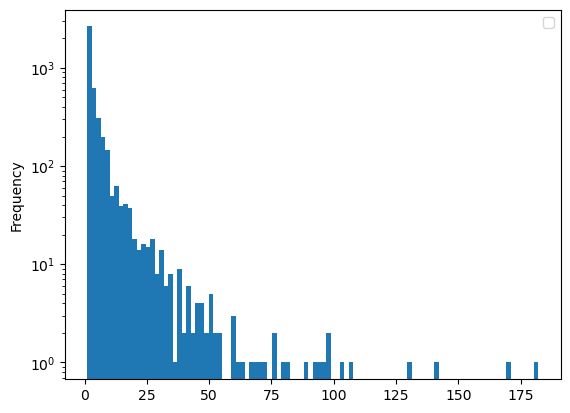

In [68]:
filtered_data.groupby(['customerId','MCC_List'])['_id'].count().reset_index().plot(kind='hist', bins=100, logy=True)

In [69]:
# build a weighted network
g = gt.Graph(directed=False)
# difine the node properties
## name: docs - title, words - 'word'
## kind: docs(customers) - 0, words(mcc) - 1
name = g.vp['name'] = g.new_vp('string')
kind = g.vp['kind'] = g.new_vp('int')
## define the edge properties
weight = g.ep['weight'] = g.new_ep('double')

docs_add = defaultdict(lambda: g.add_vertex())
words_add = defaultdict(lambda: g.add_vertex())

for _, row in df_weight_network.iterrows():
    customer = row['customerId']
    mcc = row['MCC_List']
    weight = row['amount.value']
    # add customer node
    docs = docs_add[customer]
    name[docs] = customer
    kind[docs] = 0
    # add mcc node
    words = words_add[mcc]
    name[words] = mcc
    kind[words] = 1
    edge = g.edge(docs, words)
    if edge is None:
        edge = g.add_edge(docs, words)
        g.ep['weight'][edge] = 0
    g.ep['weight'][edge] += weight

In [70]:
g

<Graph object, undirected, with 568 vertices and 4322 edges, 2 internal vertex properties, 1 internal edge property, at 0x7fdca049ac30>

In [71]:
SEED = 41
gt.seed_rng(SEED)

n_init = 10
clabel = g.vp['kind']

state_args = {'clabel': clabel, 'pclabel': clabel, 'eweight': g.ep['weight']}

mdl = np.inf
for i_n_init in range(n_init):
    base_type = gt.BlockState
    state_tmp = gt.minimize_nested_blockmodel_dl(g,
                                                 state_args=dict(base_type=base_type,**state_args),multilevel_mcmc_args=dict(verbose=False)
                                                 )
    L = 0
    for s in state_tmp.levels:
        L += 1
        if s.get_nonempty_B() < 2:
            break
    state_tmp = state_tmp.copy(bs=state_tmp.get_bs()[:L] + [np.zeros(1)])
    print(state_tmp.entropy())

    mdl_tmp = state_tmp.entropy()
    if mdl_tmp < mdl:
        mdl = 1.0*mdl_tmp
        state = state_tmp.copy()

g.state = state
g.mdl = state.entropy()
L = len(state.levels)
if L == 2:
    g.L = 1
else:
    g.L = L-2

23973.690044737203
23742.385837712867
23918.718229617978
23900.7348699143
23791.562869037407
24095.580106845224
24039.02495031217
23843.63904303318
23996.1558628201
23854.264466694643


In [72]:
print('The lowest entropy was {}, and the state has {} blocks at level 2'.format(g.state.entropy(),g.state.get_levels()[2].get_nonempty_B()))

The lowest entropy was 23742.385837712867, and the state has 3 blocks at level 2


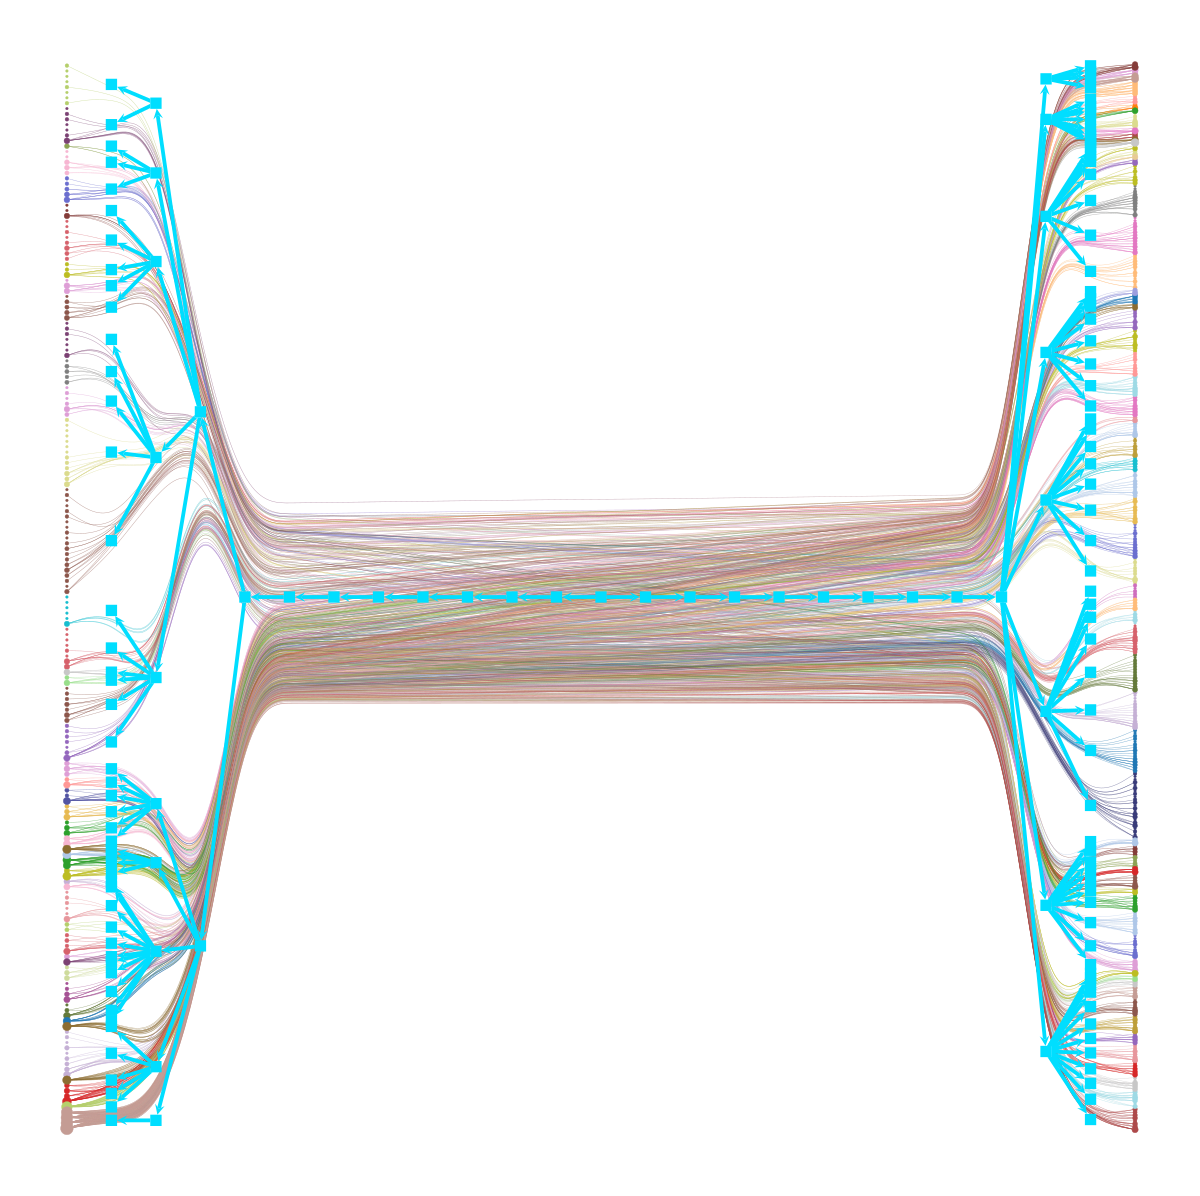

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fdca049ac30, at 0x7fdc42a8b9b0>,
 <GraphView object, directed, with 720 vertices and 719 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fdca04b1520, at 0x7fdc43729940>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fdca04b1520, at 0x7fdc437298b0>, False), at 0x7fdca04b1520>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fdca04b1520, at 0x7fdc43957c20>)

In [73]:
g.state.draw(subsample_edges=1000,layout='bipartite',bip_aspect=1,
           hvertex_size=8, hedge_pen_width=1.9, hedge_color="#00deff", hvertex_fill_color="#00DEFF", output_size=(600, 600))

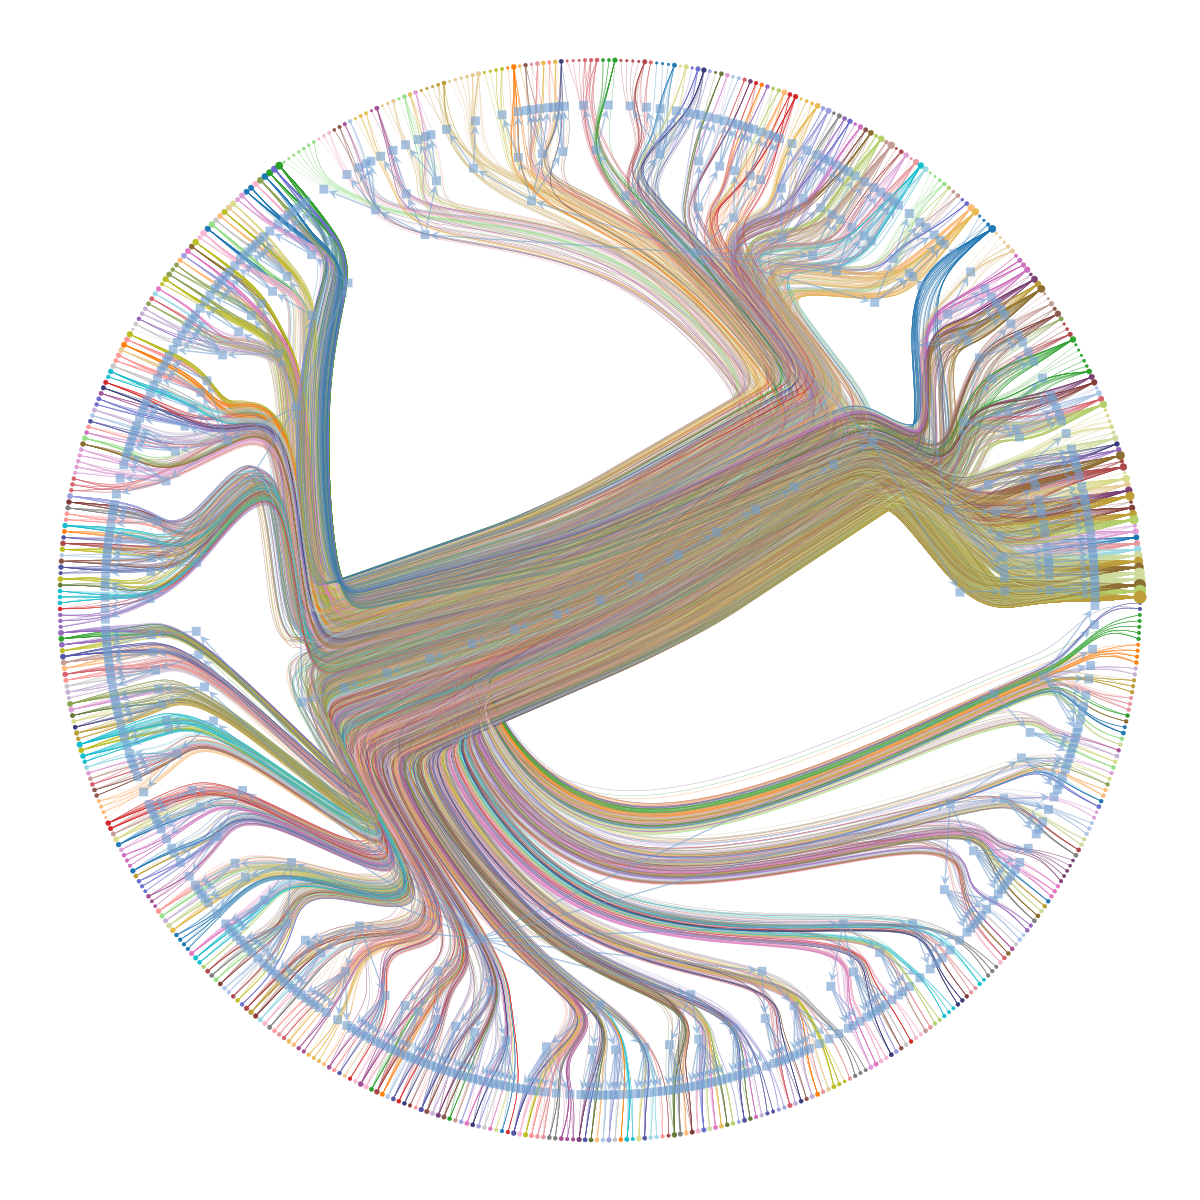

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fdcbb2d0500, at 0x7fdcb07d84a0>,
 <GraphView object, directed, with 1125 vertices and 1124 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fdcb059cc80, at 0x7fdcb043dd30>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fdcb059cc80, at 0x7fdcb043cfb0>, False), at 0x7fdcb059cc80>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fdcb059cc80, at 0x7fdcba501040>)

In [53]:
g.state.draw()

In [21]:
state.draw(layout='bipartite')

ValueError: Invalid vertex index: 1141